# AGN Damped Random Walk Example

In this notebook we run a simulation of a damped random walk AGN variability model built-in with LightCurveLynx. The model is similiar to one used in [ELAsTiCC](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/) simulations, it uses [the standard disk spectrum](https://ui.adsabs.harvard.edu/abs/1973A%26A....24..337S/abstract) as the SED "baseline" and pertrubes it stochastically.

In [ ]:
import numpy as np

from astropy.cosmology import Planck18
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.astro_utils.redshift import RedshiftDistFunc
from lightcurvelynx.base_models import FunctionNode
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.math_nodes.ra_dec_sampler import ObsTableRADECSampler
from lightcurvelynx.math_nodes.scipy_random import SamplePDF
from lightcurvelynx.models.agn import AGN
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.utils.plotting import plot_lightcurves

## Initialize Survey-related Objects

First, we'd load survey visit and noise table ("obstable"), and passband transmissions, "passband group".

In [2]:
passband_group = PassbandGroup.from_preset(
    preset="LSST",
)
# It will take a while to download it.
obstable = OpSim.from_url(
    "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs4.3/baseline/baseline_v4.3.5_10yrs.db",
)

2025-09-19 16:14:53,115 - INFO - Loading passbands from preset LSST
2025-09-19 16:14:53,116 - INFO - Data file /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/u.dat already exists. Skipping download.
2025-09-19 16:14:53,116 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/u.dat
2025-09-19 16:14:53,123 - INFO - Data file /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/g.dat already exists. Skipping download.
2025-09-19 16:14:53,123 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/g.dat
2025-09-19 16:14:53,128 - INFO - Data file /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/r.dat already exists. Skipping download.
2025-09-19 16:14:53,128 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/lightcurvelynx/data/passbands/LSST/r.dat
2025-09-19 16:14:53,132 - INF

## Create Parameter Distributions

With LightCurveLynx model parameters may be both fixed numerical values or to be drawn from random distributions.
Here we create few of AGN model parameters.

In [3]:
# Draw redshift from the uniform distribution
redshift = NumpyRandomFunc("uniform", low=0.1, high=1.0)

# Draw decimal logarithm of the black hole mass (in solar masses)
# from the uniform distribution
lg_bh_mass = NumpyRandomFunc("uniform", low=7.0, high=9.0)
# Transform to mass in solar masses
bh_mass = FunctionNode(
    lambda lg_mass: 10**lg_mass,
    lg_mass=lg_bh_mass,
    node_label="bh_mass",
)


# Eddington ratio for the accretion rate, e.g. accretion rate to critical value ratio
# First, we define a PDF function, for "blue" galaxies, see
# https://github.com/burke86/imbh_forecast/blob/master/var.ipynb
# https://ui.adsabs.harvard.edu/abs/2019ApJ...883..139S/abstract
# https://iopscience.iop.org/article/10.3847/1538-4357/aa803b/pdf
def edd_ratio_pdf(value):
    xi = 10**-1.65
    lambda_br = 10**-1.84
    delta1 = 0.471 - 0.7
    delta2 = 2.53
    min_lambda = 0.01
    max_lambda = 1.0
    value = np.asarray(value)
    fill_mask = (value >= min_lambda) & (value <= max_lambda)
    prob = np.zeros_like(value)
    prob[fill_mask] = xi / (
        (value[fill_mask] / lambda_br) ** delta1 + (value[fill_mask] / lambda_br) ** delta2
    )
    return prob


# We use a special random node to sample from this PDF
edd_ratio = SamplePDF(edd_ratio_pdf)

# We use a special distribution to draw positions from the survey coverage area
radec = ra_dec_sampler = ObsTableRADECSampler(
    obstable,
    radius=3.0,  # degrees
    node_label="ra_dec_sampler",
)

## Create a Model and Run Simulations

It is time to create the model and simulate few light curves!

In [4]:
model = AGN(
    # Reference time is not important for a stochastic model
    t0=obstable.time_bounds()[0],  # reference date, the survey start
    blackhole_mass=bh_mass,  # black hole mass in solar masses
    edd_ratio=edd_ratio,  # accretion rate to critical accretion rate raio
    redshift=redshift,
    ra=radec.ra,
    dec=radec.dec,
    cosmology=Planck18,
)

# Make it reproducible
rng = np.random.default_rng(42)

df = simulate_lightcurves(
    model=model,
    num_samples=10,
    obstable=obstable,
    passbands=passband_group,
    param_cols=[
        "ra_dec_sampler.ra",
        "ra_dec_sampler.dec",
        "bh_mass.lg_mass",
        "AGN_0.edd_ratio",
    ],
    rng=rng,
)
# params is too large to show =)
df.drop(columns=["params"])
df.iloc[0].params

{'ra_dec_sampler.ra': np.float64(40.98239526665557),
 'ra_dec_sampler.dec': np.float64(-67.99209300159761),
 'ra_dec_sampler.time': np.float64(61337.331095647605),
 'AGN_0.ra': np.float64(40.98239526665557),
 'AGN_0.dec': np.float64(-67.99209300159761),
 'AGN_0.redshift': np.float64(0.2751748370667708),
 'AGN_0.t0': np.float64(60980.00158187724),
 'AGN_0.distance': np.float64(1451333570.6546867),
 'AGN_0.blackhole_mass': np.float64(23930001.07750474),
 'AGN_0.edd_ratio': np.float64(0.040020323742432515),
 'AGN_0.inclination_rad': np.float64(1.226366294151446),
 'AGN_0.blackhole_mass_gram': np.float64(4.758265034832541e+40),
 'AGN_0.critical_accretion_rate': np.float64(3.350200150850663e+25),
 'AGN_0.blackhole_accretion_rate': np.float64(1.340760946389898e+24),
 'AGN_0.bolometric_luminosity': np.float64(1.206684851750908e+44),
 'AGN_0.mag_i': np.float64(-20.203984652010746),
 'AGN_0.sf_inf_4000aa': np.float64(0.3644950917301359),
 'AGN_0.tau_4000aa': np.float64(139.14206078508198),
 'Nu

## Plot few light curves

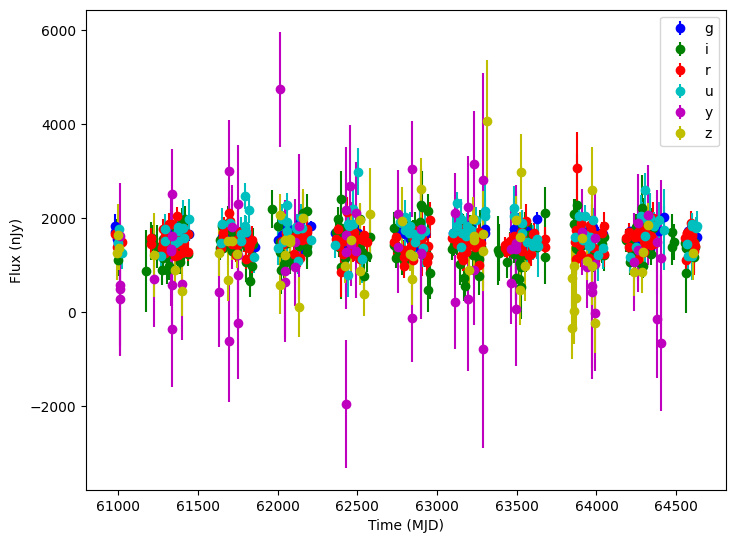

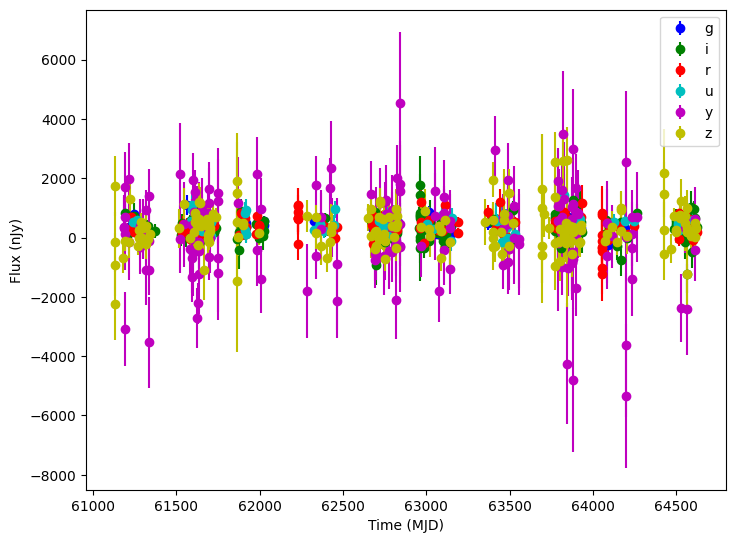

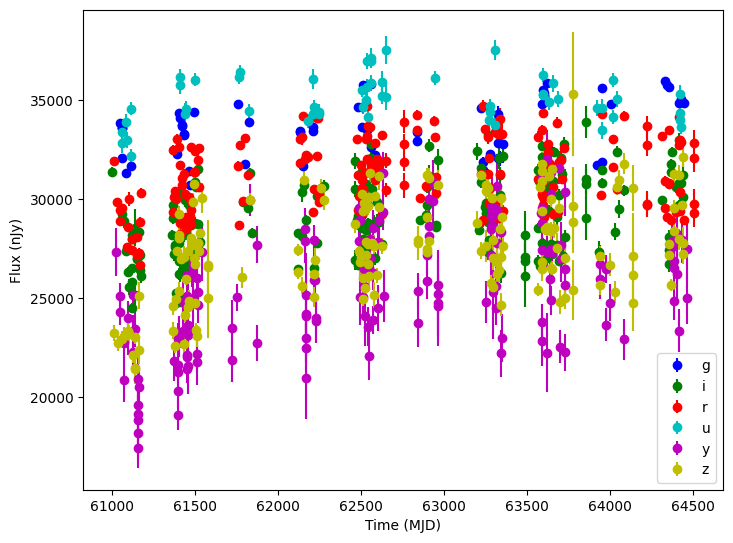

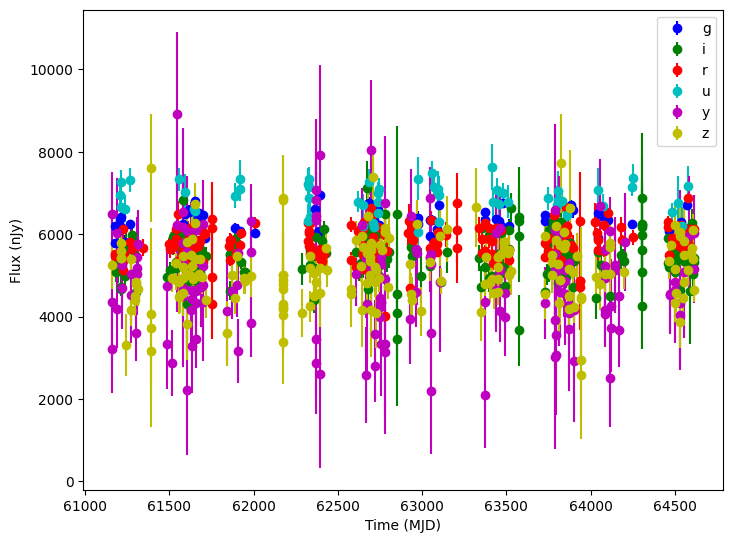

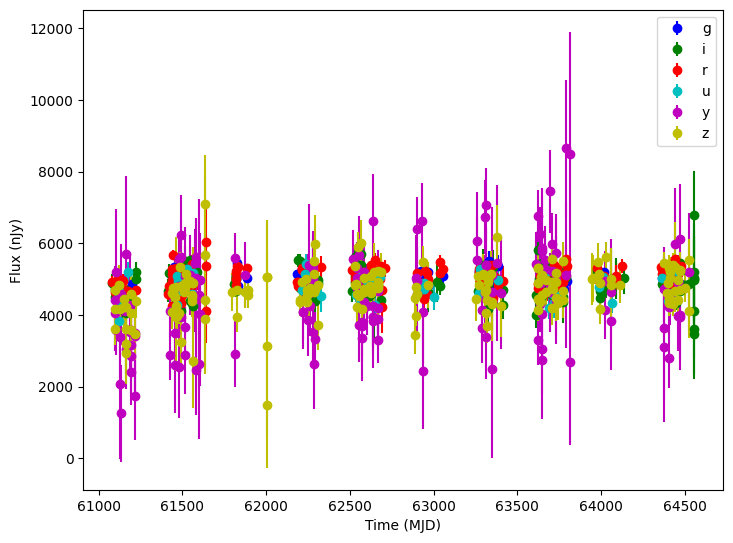

In [5]:
for idx in range(5):
    # Extract the row for this object.
    row = df.iloc[idx]
    lc = row["lightcurve"]

    plot_lightcurves(
        fluxes=lc["flux"],
        times=lc["mjd"],
        fluxerrs=lc["fluxerr"],
        filters=lc["filter"],
    )